In [1]:
from src.data_loader import load_train, load_holdout
from src.preprocess import preprocess_data
from src.model_io import load_best_model
from src.plot import plot_gain_importance, get_xgb_gain_importance, get_permutation_importance, plot_shap_summary
from sklearn.model_selection import train_test_split
import shap
from ydata_profiling import ProfileReport

In [2]:
df = load_train()
# profile = ProfileReport(
#     df,
#     title="Cell2Cell Data Profiling",
#     explorative=True
# )

# import pandas as pd

# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_churn_distribution(df, target="Churn"):
#     plt.figure(figsize=(5, 4))
#     sns.countplot(x=target, data=df)
#     plt.title("Class Distribution of Churn")
#     plt.xlabel("Churn Label")
#     plt.ylabel("Number of Samples")
#     plt.tight_layout()
#     plt.show()

# plot_churn_distribution(df)

# profile.to_file("results/data_profile.html")
df = preprocess_data(df)
df

🧹 Removed users with missing rate ≥ 10%: 156 rows dropped (51047 → 50891)


,CustomerID,Churn,月均消费金额,月通话分钟数,每月固定套餐费用,人工协助拨号次数,超出套餐的通话分钟数,漫游通话次数,通话分钟数环比变化率,消费金额环比变化率,...,PRIZM市场细分编码_Town,职业类别_Crafts,职业类别_Homemaker,职业类别_Other,职业类别_Professional,职业类别_Retired,职业类别_Self,职业类别_Student,婚姻状况_Unknown,婚姻状况_Yes
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,False,False,False,False,True,False,False,False,False,False
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,False,False,False,False,True,False,False,False,False,True
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,True,True,False,False,False,False,False,False,False,True
3,3000022,0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,False,False,False,True,False,False,False,False,False,False
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51037,3399906,0,31.92,63.0,17.0,0.00,43.0,0.0,-38.0,-13.2,...,False,False,False,True,False,False,False,False,False,True
51039,3399922,0,50.00,492.0,50.0,0.00,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,True,False
51040,3399942,0,71.99,724.0,70.0,0.00,4.0,0.9,-40.0,-2.0,...,False,False,False,False,True,False,False,False,True,False
51041,3399946,1,117.49,384.0,30.0,0.00,250.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True



⚠️  [Warning] 以下特征对 F1 得分有负面影响 (Permutation Importance < 0):
     feature  importance
职业类别_Student   -0.000211
💡 建议：尝试剔除这些特征以提升模型泛化能力。



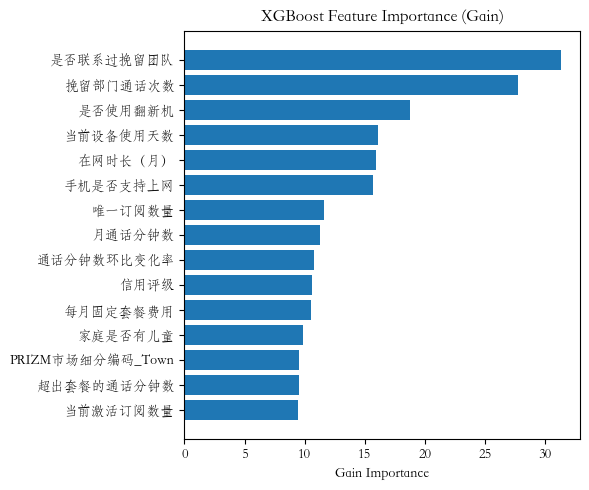

In [3]:
target = "Churn"
id_col = "CustomerID"

X = df.drop(columns=[target, id_col])
y = df[target]

# ===== 1. 加载模型 =====
best_model, meta = load_best_model()
feature_cols = meta["feature_cols"]

# ===== 2. 构造数据 =====
X = df[feature_cols]
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_explain = X_valid[meta["feature_cols"]]

# ===== 3. 计算重要性 =====
gain_df = get_xgb_gain_importance(best_model, feature_cols)
perm_df = get_permutation_importance(
    best_model,
    X_valid,
    y_valid,
    scoring="f1"
)

# ===== 4. 画图 =====

plot_gain_importance(
    gain_df,
    top_k=15,
    save_path="results/gain_importance_top15.png"
)

📊 Saved SHAP bar plot to: results/shap_bar_model.png


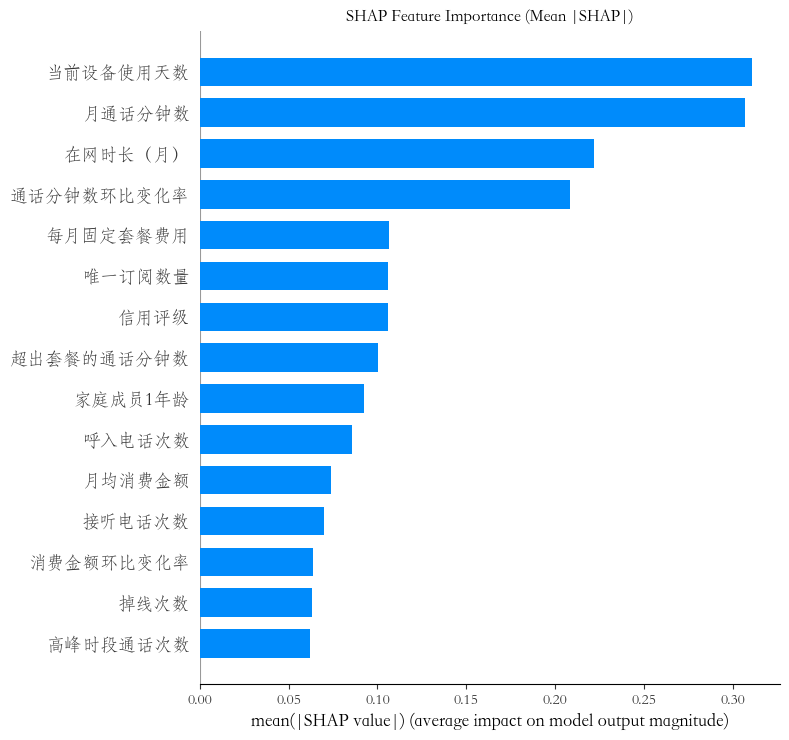

🐝 Saved SHAP beeswarm plot to: results/shap_beeswarm_model.png


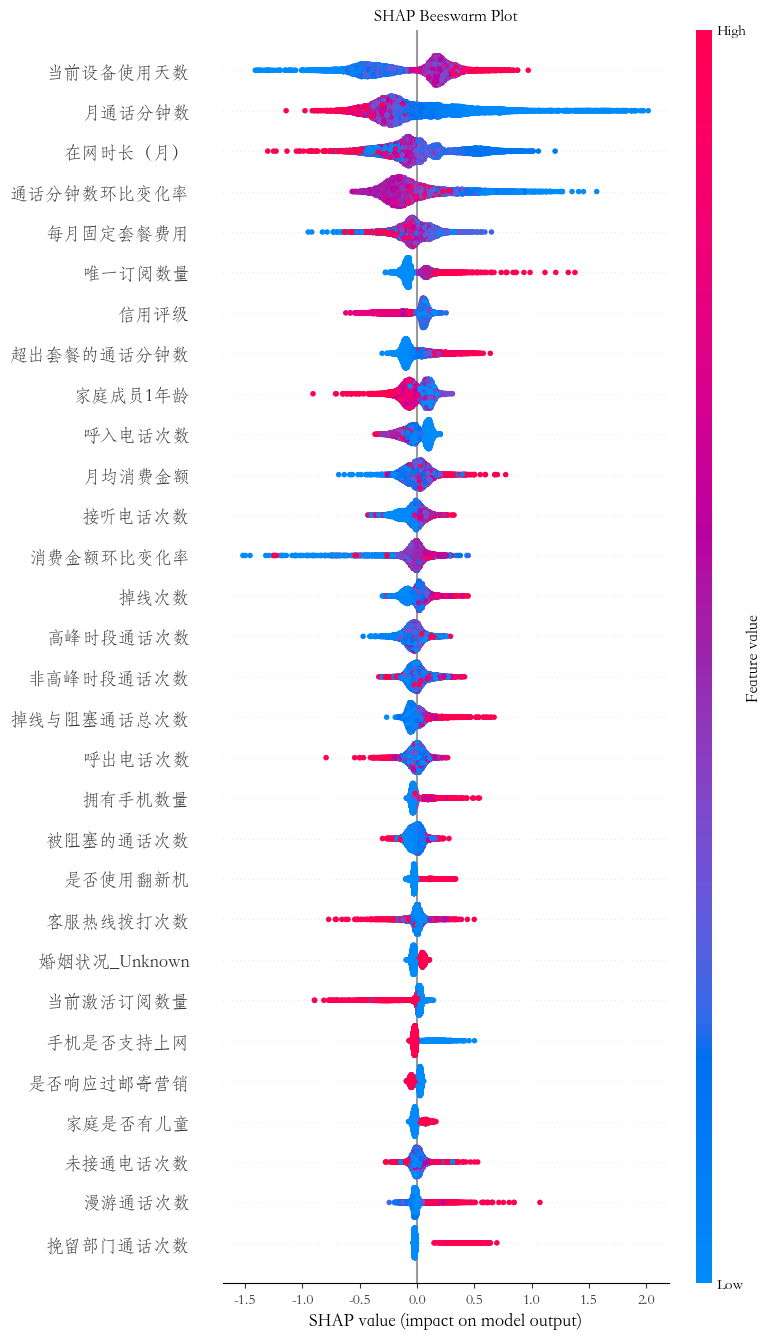

In [4]:
plot_shap_summary(
    model=best_model,
    X=X_explain,
    max_display_bar=15,
    max_display_beeswarm=30
)